<a href="https://colab.research.google.com/github/wahyuejunian/GWO-MT1D/blob/main/GWO_MT_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GWO Algorithm (Syntetic Data)**

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def MT1D(resistivities, thicknesses, frequency):
    mu = 4 * np.pi * 1E-7  # Magnetic Permeability (H/m)
    w = 2 * np.pi * frequency  # Angular Frequency (Radians)
    n = len(resistivities)  # Number of Layers

    impedances = np.zeros(len(frequency), dtype=complex)  # Initialize impedances

    for i in range(len(frequency)):  # Loop through frequencies
        Zn = np.sqrt(1j * w[i] * mu * resistivities[-1])  # Calculate Zn for each frequency
        impedances[i] = Zn  # Assign Zn to impedances

        for j in range(n - 1, 0, -1):
            resistivity = resistivities[j - 1]
            thickness = thicknesses[j - 1]

            dj = np.sqrt(1j * w[i] * mu / resistivity)
            wj = dj * resistivity
            ej = np.exp(-2 * thickness * dj)
            belowImpedance = impedances[i]
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances[i] = Zj  # Update impedances

    return impedances

# Model Selection
Modelname = '1' # select the model to be calculated

if Modelname == '1':
    rsyn = np.array([100, 1000, 10])
    tsyn = np.array([500, 1000])
elif Modelname == '2':
    rsyn = np.array([100, 10, 1000])
    tsyn = np.array([500, 1000])

ndata = 56
freq = np.logspace(-3, 4, ndata)  # frequency from 10^-3 to 10^4

Impedance = MT1D(rsyn, tsyn, freq)  # calculate synthetic model using MT1D function

mu0 = 4 * np.pi * 1E-7  # Magnetic Permeability (H/m)
noise_level = 0.05 # 5% noise

appRes_noise = np.zeros(ndata)
phase_noise = np.zeros(ndata)

for idat in range(ndata):
    omega = 2 * np.pi * freq[idat]
    Z = Impedance[idat]

    absZ = np.abs(Z)
    appRes = (absZ ** 2) / (omega * mu0)
    phase = np.degrees(np.arctan2(np.imag(Z), np.real(Z)))

    # Add noise 5%
    Z_noise = Z + Z * noise_level * np.random.randn()
    zre_noise = np.real(Z) + np.real(Z) * noise_level * np.random.randn()
    zim_noise = np.imag(Z) + np.imag(Z) * noise_level * np.random.randn()

    appRes_noise[idat] = (np.abs(Z_noise) ** 2) / (omega * mu0)
    phase_noise[idat] = np.degrees(np.arctan2(zim_noise, zre_noise))

# Save data to a text file
data = np.column_stack((freq, appRes_noise, phase_noise))
np.savetxt(f'Data Synthetic Model_{Modelname}.txt', data, header="Frequency Apparent Resistivity Phase", comments='')


direktori = "/content"
print(f"Data sudah tersimpan di direktori: {direktori}/Data Synthetic Model_{Modelname}.txt")

Data sudah tersimpan di direktori: /content/Data Synthetic Model_1.txt


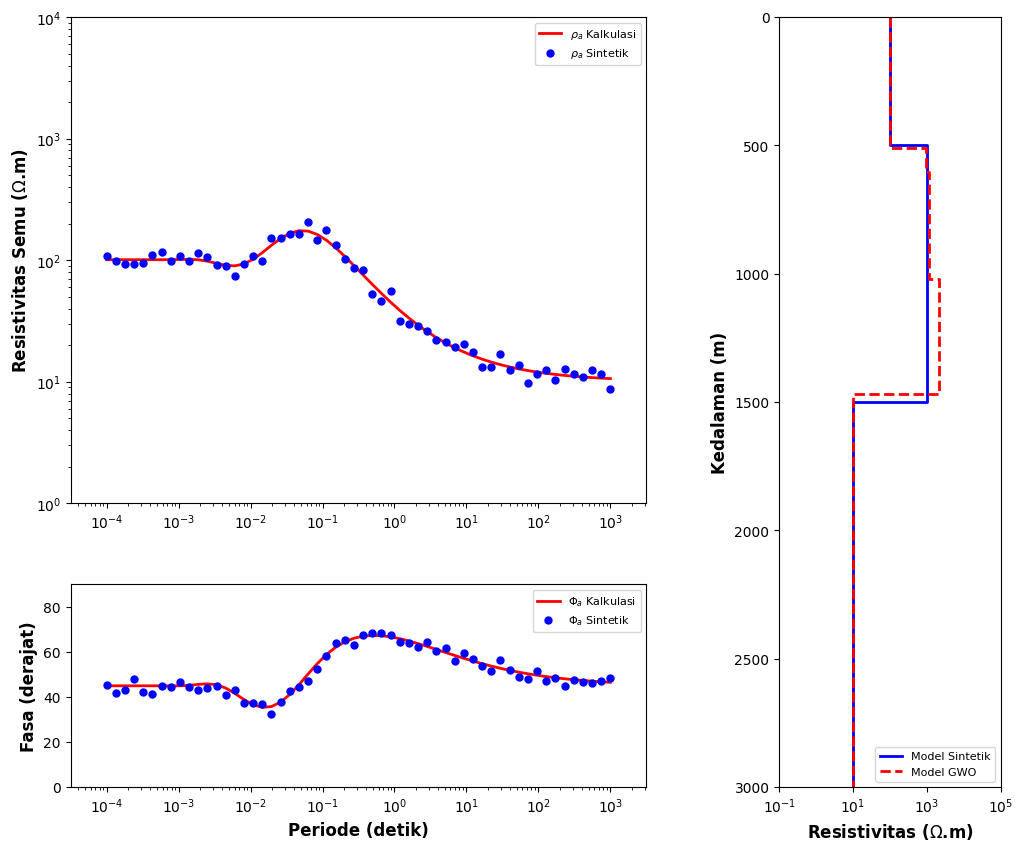

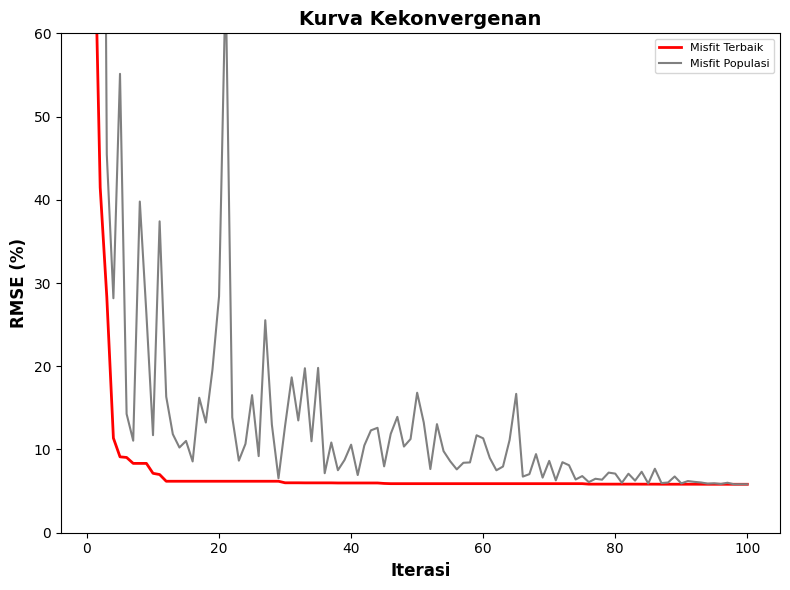

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def MT1D(resistivities, thicknesses, frequency):
    mu = 4 * np.pi * 1E-7  # Magnetic Permeability (H/m)
    w = 2 * np.pi * frequency  # Angular Frequency (Radians)
    n = len(resistivities)  # Number of Layers

    impedances = np.zeros(len(frequency), dtype=complex)  # Initialize impedances
    apparentResistivity = np.zeros_like(frequency)
    phase = np.zeros_like(frequency)

    for i in range(len(frequency)):  # Loop through frequencies
        Zn = np.sqrt(1j * w[i] * mu * resistivities[-1])  # Calculate Zn for each frequency
        impedances[i] = Zn  # Assign Zn to impedances

        for j in range(n - 1, 0, -1):
            resistivity = resistivities[j - 1]
            thickness = thicknesses[j - 1]

            dj = np.sqrt(1j * w[i] * mu / resistivity)
            wj = dj * resistivity
            ej = np.exp(-2 * thickness * dj)
            belowImpedance = impedances[i]
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances[i] = Zj  # Update impedances

        Z = impedances[i]
        absZ = np.abs(Z)
        apparentResistivity[i] = (absZ**2) / (mu * w[i])
        phase[i] = np.degrees(np.arctan2(np.imag(Z), np.real(Z)))

    return apparentResistivity, phase

def misfit(rho_obs, phase_obs, rho_cal, phase_cal):
    nd = len(rho_obs)
    m = np.sqrt((1 / nd) * np.sum((np.log10(rho_obs / rho_cal))**2 +
                                   (np.deg2rad(phase_obs) - np.deg2rad(phase_cal))**2))
    return np.sum(m)*100

# Load data and set model parameters based on Modelname
Modelname = '1'
filename = f'Data Synthetic Model_{Modelname}.txt'
data = np.loadtxt(filename, delimiter=' ', skiprows=1)

if Modelname == '1':
    rsyn = np.array([100, 1000, 10])
    tsyn = np.array([500, 1000])
elif Modelname == '2':
    rsyn = np.array([100, 10, 1000])
    tsyn = np.array([500, 1000])


# Extract columns from the loaded data
freq = data[:, 0]  # Frequency
app_data = data[:, 1]  # Apparent Resistivity
phase_data = data[:, 2]  # Phase

# Inversion parameters
npop = 100                 # Number of populations/models
nlayer = 5                # Number of predicted layers
niter = 100               # Number of iterations

# A priori information with individual layer bounds
rmin = np.array([1, 1, 1, 1, 1])
rmax = np.array([3000, 3000, 3000, 3000, 3000])
tmin = np.array([1, 1, 1, 1])
tmax = np.array([2000, 2000, 2000, 2000])

# Initialize matrices
rho = np.zeros((npop, nlayer))
thick = np.zeros((npop, nlayer - 1))
rhoapp_mod = np.zeros((npop, len(freq)))
phase_mod = np.zeros((npop, len(freq)))
E = np.zeros(npop)
Apha_curve = np.zeros(niter)
Beta_curve = np.zeros(niter)
Delta_curve = np.zeros(niter)
Omega_curve = np.zeros(niter)

# GWO main program
for ipop in range(npop):
    rho[ipop] = rmin + np.random.rand(nlayer) * (rmax - rmin)
    thick[ipop] = tmin + np.random.rand(nlayer - 1) * (tmax - tmin)

# Initialize alpha, beta, and delta positions
Alpha_score = np.inf
Beta_score = np.inf
Delta_score = np.inf

Alpha_rho = np.zeros(nlayer)
Alpha_thick = np.zeros(nlayer - 1)
Beta_rho = np.zeros(nlayer)
Beta_thick = np.zeros(nlayer - 1)
Delta_rho = np.zeros(nlayer)
Delta_thick = np.zeros(nlayer - 1)

# Main Loop
for iter in range(niter):
    for ipop in range(npop):
        # Calculate objective function for each search agent and evaluate misfit
        apparentResistivity, phase = MT1D(rho[ipop], thick[ipop], freq)
        rhoapp_mod[ipop] = apparentResistivity
        phase_mod[ipop] = phase

        fitness = misfit(app_data, phase_data, rhoapp_mod[ipop], phase_mod[ipop])

        if fitness < Alpha_score:
            Alpha_score = fitness
            Alpha_rho = rho[ipop].copy()
            Alpha_thick = thick[ipop].copy()
        elif fitness > Alpha_score and fitness < Beta_score:
            Beta_score = fitness
            Beta_rho = rho[ipop].copy()
            Beta_thick = thick[ipop].copy()
        elif fitness > Alpha_score and fitness > Beta_score and fitness < Delta_score:
            Delta_score = fitness
            Delta_rho = rho[ipop].copy()
            Delta_thick = thick[ipop].copy()

    a = 2 - iter * (2 / niter)

    for ipop in range(npop):
        for imod in range(nlayer):
            #Alpha
            r1 = np.random.rand()
            r2 = np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_Alpha_rho = np.abs(C1 * Alpha_rho[imod] - rho[ipop, imod])
            X1_rho = Alpha_rho[imod] - A1 * D_Alpha_rho

            #Beta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_Beta_rho = np.abs(C2 * Beta_rho[imod] - rho[ipop, imod])
            X2_rho = Beta_rho[imod] - A2 * D_Beta_rho

            #Delta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_Delta_rho = np.abs(C3 * Delta_rho[imod] - rho[ipop, imod])
            X3_rho = Delta_rho[imod] - A3 * D_Delta_rho

            rho[ipop, imod] = np.clip((X1_rho + X2_rho + X3_rho) / 3, rmin[imod], rmax[imod])

        for imod in range(nlayer - 1):
            #Alpha
            r1 = np.random.rand()
            r2 = np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_Alpha_thick = np.abs(C1 * Alpha_thick[imod] - thick[ipop, imod])
            X1_thick = Alpha_thick[imod] - A1 * D_Alpha_thick

            #Beta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_Beta_thick = np.abs(C2 * Beta_thick[imod] - thick[ipop, imod])
            X2_thick = Beta_thick[imod] - A2 * D_Beta_thick

            #Delta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_Delta_thick = np.abs(C3 * Delta_thick[imod] - thick[ipop, imod])
            X3_thick = Delta_thick[imod] - A3 * D_Delta_thick

            thick[ipop, imod] = np.clip((X1_thick + X2_thick + X3_thick) / 3, tmin[imod], tmax[imod])


    Apha_curve[iter] = Alpha_score
    Beta_curve[iter] = Beta_score
    Delta_curve[iter] = Delta_score

    apparentResistivity_Alpha, phase_Alpha = MT1D(Alpha_rho, Alpha_thick, freq)
    app_Alpha = apparentResistivity_Alpha
    phase_Alpha = phase_Alpha

    apparentResistivity, phase = MT1D(rho[ipop], thick[ipop], freq)
    rhoapp_mod[ipop] = apparentResistivity
    phase_mod[ipop] = phase

    fitness = misfit(app_data, phase_data, rhoapp_mod[ipop], phase_mod[ipop])
    Omega_curve[iter] = fitness

# Plotting the results
plt.figure(figsize=(12, 10))

# Subplot 1: Apparent Resistivity vs Periods
plt.subplot(3, 3, (1, 5))
#plt.xlabel('Periode (detik)', fontsize=12, fontweight='bold')
plt.ylabel(r'Resistivitas Semu ($\Omega$.m)', fontsize=12, fontweight='bold')
plt.loglog(1/freq, app_Alpha, 'r-', 1/freq, app_data, 'ob', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(1e0, 1e4)
plt.legend([(r'$\rho_a$ Kalkulasi'), (r'$\rho_a$ Sintetik')], loc='best', fontsize=8)
#plt.grid(False, which='both', linestyle='-', linewidth=0.3)

# Subplot 2: Phase vs Periods
plt.subplot(3, 3, (7, 8))
plt.xlabel('Periode (detik)', fontsize=12, fontweight='bold')
plt.ylabel('Fasa (derajat)', fontsize=12, fontweight='bold')
plt.semilogx(1/freq, phase_Alpha, 'r-', 1/freq, phase_data, 'ob', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(0, 90)
plt.legend([(r'$\Phi_a$ Kalkulasi'), (r'$\Phi_a$ Sintetik')], loc='best', fontsize=8)
#plt.grid(False, which='both', linestyle='-', linewidth=0.3)

# Subplot 3: 1D MT Model Plot
plt.subplot(3, 3, (3, 9))
#plt.title('1D MT Model', fontsize=14, fontweight='bold')
plt.xlabel('Resistivitas ($\Omega$.m)', fontsize=12, fontweight='bold')
plt.ylabel('Kedalaman (m)', fontsize=12, fontweight='bold')
plt.step([rsyn[0]] + rsyn.tolist(), [0] + np.cumsum(tsyn).tolist() + [max(tsyn) * 1000], where='post', color='b', linewidth=2)
r = [Alpha_rho[0]] + Alpha_rho.tolist()
t = [0] + np.cumsum(Alpha_thick).tolist() + [max(Alpha_thick) * 1000]
plt.step(r, t, where='post', color='r', linewidth=2, linestyle='--')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(1e-1, 1e5)
plt.ylim(0, 3000)
plt.gca().invert_yaxis()
plt.legend(['Model Sintetik', 'Model GWO'], loc='lower right', fontsize=8)
plt.subplots_adjust(wspace=0.6, hspace=0.4)
plt.savefig('1D_MT_Model_2.png', format='png', dpi=300)

# Plot 4: Convergence Curve
plt.figure(figsize=(8, 6))
iterations = range(1, niter + 1)
plt.title('Kurva Kekonvergenan', fontsize=14, fontweight='bold')
plt.xlabel('Iterasi', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (%)', fontsize=12, fontweight='bold')
plt.plot(iterations, Apha_curve, '-r', linewidth=2)
plt.plot(iterations, Omega_curve, color='gray', linewidth=1.5)
plt.legend(['Misfit Terbaik', 'Misfit Populasi'], loc='upper right', fontsize=8)
plt.savefig('Convergence_Curve2.png', format='png', dpi=500)
plt.ylim(0, 60)

plt.tight_layout()
plt.show()

# **GWO Algorithm (Data Lapangan)**

In [8]:
!pip install mtpy
!pip install geopandas
import numpy as np
np.float = float
np.complex = complex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mtpy: filename=mtpy-1.1.5-py3-none-any.whl size=1183156 sha256=ed6e978976302db0b079d4cce2944c77c1562e95f6ef9e7a5620ff59949a3ad5
  Stored in directory: /root/.cache/pip/wheels/9e/3f/04/c627e84fb80a80c8cc4d6231693477b6aa017857281cde2e2c
Successfully built mtpy


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

Ignore GDAL as it is not working. Will use pyproj


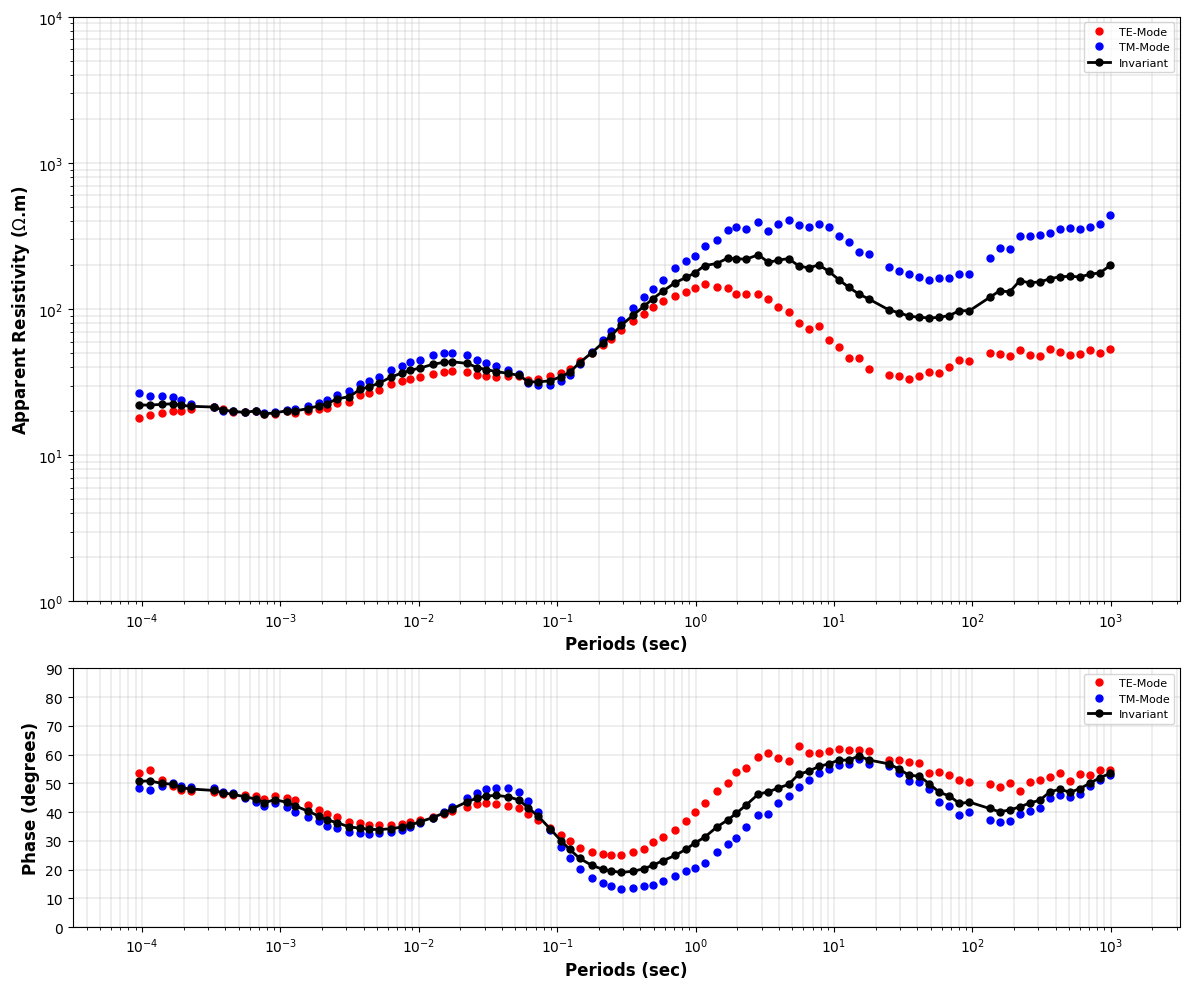

Rho_inv [22.073476131272955, 22.036919781118133, 22.29001673611111, 22.503676833333337, 21.97762846584068, 21.61620227272728, 21.366277044574318, 20.398896346153844, 19.95549568181818, 19.625730277777784, 20.146022666666667, 19.22269576923077, 19.45292772727273, 20.160283351142592, 20.128340614508623, 20.825428274111175, 21.768985644125422, 22.532874338955025, 24.33620427614632, 25.14560772846591, 28.22807018206642, 29.360416024592865, 31.050179701184966, 34.27307244962216, 36.50685105740182, 38.18640475152572, 39.535618431897795, 41.87489390504975, 43.185902840737384, 43.628978488052056, 42.473648888389846, 39.79392734022806, 38.54587353846154, 37.381022909090916, 36.27376222222222, 35.199070933333346, 31.88988953846154, 31.679425818181826, 32.36334977777778, 34.37708906666667, 36.932170461538455, 42.97891563636363, 50.26981777777778, 58.59535089590443, 65.9651650135368, 77.35355142524725, 91.22922447564875, 105.08873986774745, 117.80909266371243, 132.65312681791744, 151.5056934566145

In [1]:
import numpy as np
import mtpy
from mtpy.core.mt import MT
import matplotlib.pyplot as plt
import pandas as pd

# Read EDI file
edi_fn = '/content/ET15n.edi'
np.float = float  # Now np.float is referencing the built-in float
np.complex = complex  # Same for np.complex
mt_obj = MT(edi_fn)

# Frequency, apparent resistivity, and phase extraction
frequencies = mt_obj.Z.freq
rho_xy = mt_obj.Z.resistivity[:, 0, 1]  # Apparent resistivity rho_xy
rho_yx = mt_obj.Z.resistivity[:, 1, 0]  # Apparent resistivity rho_yx
phs_xy = mt_obj.Z.phase[:, 0, 1]  # Phase phs_xy
phs_yx = mt_obj.Z.phase[:, 1, 0]  # Phase phs_yx

# Create a list to save the results
rho_av_list = []
phs_av_list = []

# Loop through data
for i in range(len(frequencies)):
    # Get data for each frequency
    rho_xy_val = rho_xy[i]
    rho_yx_val = rho_yx[i]
    phs_xy_val = phs_xy[i]
    phs_yx_val = phs_yx[i]

    # Convert phase from degrees to radians
    phs_xy_rad = np.deg2rad(phs_xy_val)
    phs_yx_rad = np.deg2rad(phs_yx_val + 180)  # Adds 180 degrees to TM phase

   # Calculation for average central impedance
    rho_av = 0.25 * (rho_xy_val + rho_yx_val + 2 * np.sqrt(rho_xy_val * rho_yx_val) * np.cos(phs_xy_rad - phs_yx_rad))
    X = np.sqrt(rho_xy_val) * np.sin(phs_xy_rad) + np.sqrt(rho_yx_val) * np.sin(phs_yx_rad)
    Y = np.sqrt(rho_xy_val) * np.cos(phs_xy_rad) + np.sqrt(rho_yx_val) * np.cos(phs_yx_rad)
    phs_av = np.arctan2(X, Y)  # Average phase in radians

   # Save results to list
    rho_av_list.append(rho_av)
    phs_av_list.append(np.rad2deg(phs_av))  # Convert back to degrees

# Plotting the results
plt.figure(figsize=(12, 10))

# Subplot 1: Apparent Resistivity vs Periods
plt.subplot(3, 2, (1, 4))
plt.xlabel('Periods (sec)', fontsize=12, fontweight='bold')
plt.ylabel(r'Apparent Resistivity ($\Omega$.m)', fontsize=12, fontweight='bold')
plt.loglog(1/frequencies, rho_xy, 'or', 1/frequencies, rho_yx, 'ob', 1/frequencies, rho_av_list, '-ok', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(1e0, 1e4)
plt.legend(['TE-Mode', 'TM-Mode', 'Invariant'], loc='best', fontsize=8)
plt.grid(True, which='both', linestyle='-', linewidth=0.3)

# Subplot 2: Phase vs Periods
plt.subplot(3, 2, (5, 6))
plt.xlabel('Periods (sec)', fontsize=12, fontweight='bold')
plt.ylabel('Phase (degrees)', fontsize=12, fontweight='bold')
plt.semilogx(1/frequencies, phs_xy, 'or', 1/frequencies, phs_yx + 180, 'ob', 1/frequencies, phs_av_list, '-ok', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(0, 90)
plt.legend(['TE-Mode', 'TM-Mode', 'Invariant'], loc='best', fontsize=8)
plt.grid(True, which='both', linestyle='-', linewidth=0.3)
plt.tight_layout()
plt.show()

# Showing results
print(f"Rho_inv {rho_av_list}")
print(f"Phs_inv {phs_av_list}")

# Create a DataFrame with the data you want to store.
data = {
    'Frequency (Hz)': frequencies,  # Use frequencies instead of freq
    'Rho_inv (Ohm.m)': rho_av_list,
    'Phs_inv (Degrees)': phs_av_list
}

df = pd.DataFrame(data)

# Save DataFrame to TXT file
file_path = 'datalapangan_15n.txt'
df.to_csv(file_path, sep='\t', index=False)

print(f"Data telah disimpan di {file_path}")


Iteration 1: Alpha_score = 88.74821444884834
Iteration 2: Alpha_score = 73.15352606288916
Iteration 3: Alpha_score = 68.17902426842123
Iteration 4: Alpha_score = 55.66350837857594
Iteration 5: Alpha_score = 50.53305633987291
Iteration 6: Alpha_score = 34.911240678910374
Iteration 7: Alpha_score = 34.911240678910374
Iteration 8: Alpha_score = 34.911240678910374
Iteration 9: Alpha_score = 32.57485200264509
Iteration 10: Alpha_score = 26.61540075290195
Iteration 11: Alpha_score = 26.61540075290195
Iteration 12: Alpha_score = 25.26670937046865
Iteration 13: Alpha_score = 25.26670937046865
Iteration 14: Alpha_score = 25.26670937046865
Iteration 15: Alpha_score = 25.26670937046865
Iteration 16: Alpha_score = 25.26670937046865
Iteration 17: Alpha_score = 25.26670937046865
Iteration 18: Alpha_score = 25.26670937046865
Iteration 19: Alpha_score = 21.786917854104782
Iteration 20: Alpha_score = 21.403328690064292
Iteration 21: Alpha_score = 20.542860944959408
Iteration 22: Alpha_score = 19.207800

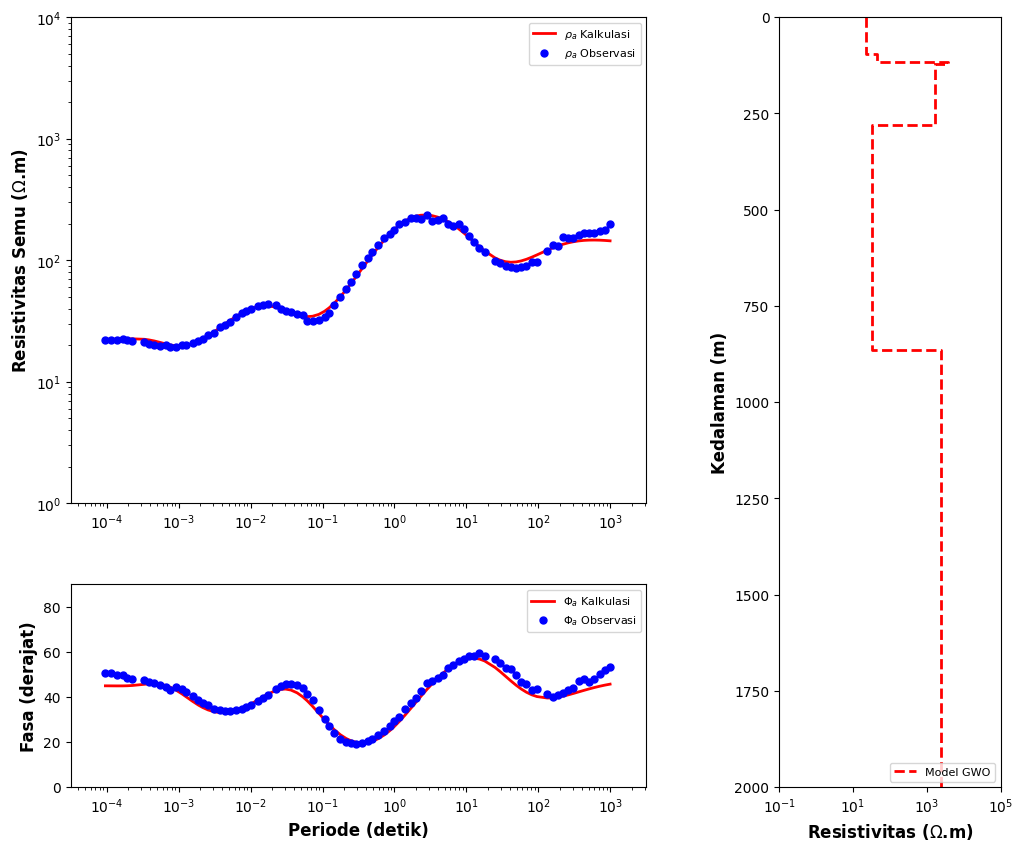

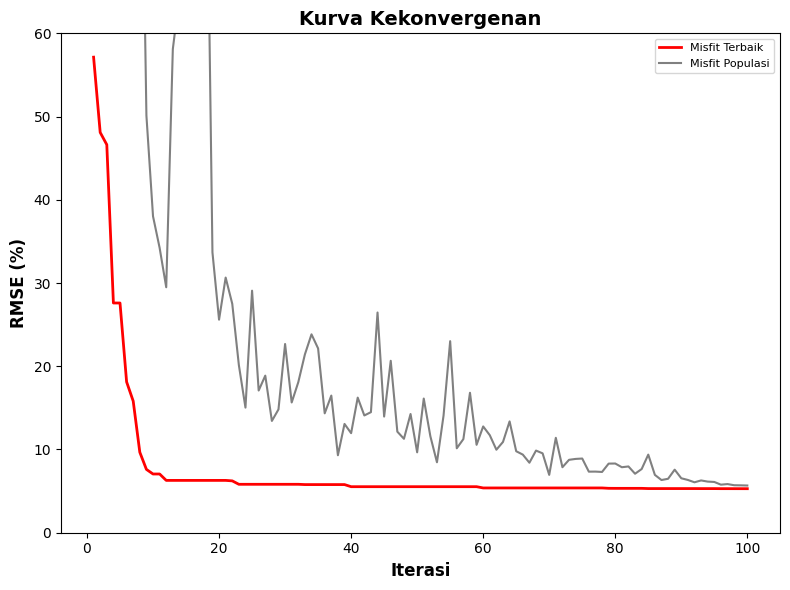

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def MT1D(resistivities, thicknesses, frequency):
    mu = 4 * np.pi * 1E-7  # Magnetic Permeability (H/m)
    w = 2 * np.pi * frequency  # Angular Frequency (Radians)
    n = len(resistivities)  # Number of Layers

    impedances = np.zeros(len(frequency), dtype=complex)  # Initialize impedances
    apparentResistivity = np.zeros_like(frequency)
    phase = np.zeros_like(frequency)

    for i in range(len(frequency)):  # Loop through frequencies
        Zn = np.sqrt(1j * w[i] * mu * resistivities[-1])  # Calculate Zn for each frequency
        impedances[i] = Zn  # Assign Zn to impedances

        for j in range(n - 1, 0, -1):
            resistivity = resistivities[j - 1]
            thickness = thicknesses[j - 1]

            dj = np.sqrt(1j * w[i] * mu / resistivity)
            wj = dj * resistivity
            ej = np.exp(-2 * thickness * dj)
            belowImpedance = impedances[i]
            rj = (wj - belowImpedance) / (wj + belowImpedance)
            re = rj * ej
            Zj = wj * ((1 - re) / (1 + re))
            impedances[i] = Zj  # Update impedances

        Z = impedances[i]
        absZ = np.abs(Z)
        apparentResistivity[i] = (absZ**2) / (mu * w[i])
        phase[i] = np.degrees(np.arctan2(np.imag(Z), np.real(Z)))

    return apparentResistivity, phase

def misfit(rho_obs, phase_obs, rho_cal, phase_cal):
    nd = len(rho_obs)
    m = np.sqrt((1 / nd) * np.sum((np.log10(rho_obs / rho_cal))**2 +
                                   (np.deg2rad(phase_obs) - np.deg2rad(phase_cal))**2))
    return np.sum(m)*100

# Load data
data = np.loadtxt('/content/datalapangan_15n.txt', skiprows=1)  # Adjust filename as necessary

# Extract columns from the loaded data
freq = data[:, 0]  # Frequency (Hz)
rho_inv = data[:, 1]    # Rho_inv (Ohm.m)
phs_inv = data[:, 2]    # Phs_inv (Degrees)

# Inversion parameters
npop = 100                 # Number of populations/models
nlayer = 10                # Number of predicted layers
niter = 100               # Number of iterations

# A priori information with individual layer bounds
rmin=np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
rmax=np.array([1500, 2000, 5000, 10000, 11000, 10000, 9000, 12000, 15000, 15000])
tmin=np.array([5, 5, 5, 60, 300, 500, 600, 800, 1000])
tmax=np.array([100, 100, 500, 2000, 5000, 10000, 30000, 90000,150000])

# Initialize matrices
rho = np.zeros((npop, nlayer))
thick = np.zeros((npop, nlayer - 1))
rhoapp_mod = np.zeros((npop, len(freq)))
phase_mod = np.zeros((npop, len(freq)))
E = np.zeros(npop)
Alpha_curve = np.zeros(niter)
Beta_curve = np.zeros(niter)
Delta_curve = np.zeros(niter)
Omega_curve = np.zeros(niter)

# GWO main program
for ipop in range(npop):
    rho[ipop] = rmin + np.random.rand(nlayer) * (rmax - rmin)
    thick[ipop] = tmin + np.random.rand(nlayer - 1) * (tmax - tmin)

# Initialize alpha, beta, and delta positions
Alpha_score = np.inf
Beta_score = np.inf
Delta_score = np.inf

Alpha_rho = np.zeros(nlayer)
Alpha_thick = np.zeros(nlayer - 1)
Beta_rho = np.zeros(nlayer)
Beta_thick = np.zeros(nlayer - 1)
Delta_rho = np.zeros(nlayer)
Delta_thick = np.zeros(nlayer - 1)

# Main Loop
for iter in range(niter):
    for ipop in range(npop):
        # Calculate objective function for each search agent and evaluate misfit
        apparentResistivity, phase = MT1D(rho[ipop], thick[ipop], freq)
        rhoapp_mod[ipop] = apparentResistivity
        phase_mod[ipop] = phase

        fitness = misfit(rho_inv, phs_inv, rhoapp_mod[ipop], phase_mod[ipop])

        if fitness < Alpha_score:
            Alpha_score = fitness
            Alpha_rho = rho[ipop].copy()
            Alpha_thick = thick[ipop].copy()
        elif fitness > Alpha_score and fitness < Beta_score:
            Beta_score = fitness
            Beta_rho = rho[ipop].copy()
            Beta_thick = thick[ipop].copy()
        elif fitness > Alpha_score and fitness > Beta_score and fitness < Delta_score:
            Delta_score = fitness
            Delta_rho = rho[ipop].copy()
            Delta_thick = thick[ipop].copy()

    a = 2 - iter * (2 / niter)

    for ipop in range(npop):
        for imod in range(nlayer):
            #Alpha
            r1 = np.random.rand()
            r2 = np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_Alpha_rho = np.abs(C1 * Alpha_rho[imod] - rho[ipop, imod])
            X1_rho = Alpha_rho[imod] - A1 * D_Alpha_rho

            #Beta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_Beta_rho = np.abs(C2 * Beta_rho[imod] - rho[ipop, imod])
            X2_rho = Beta_rho[imod] - A2 * D_Beta_rho

            #Delta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_Delta_rho = np.abs(C3 * Delta_rho[imod] - rho[ipop, imod])
            X3_rho = Delta_rho[imod] - A3 * D_Delta_rho

            rho[ipop, imod] = np.clip((X1_rho + X2_rho + X3_rho) / 3, rmin[imod], rmax[imod])

        for imod in range(nlayer - 1):
            #Alpha
            r1 = np.random.rand()
            r2 = np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2
            D_Alpha_thick = np.abs(C1 * Alpha_thick[imod] - thick[ipop, imod])
            X1_thick = Alpha_thick[imod] - A1 * D_Alpha_thick

            #Beta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2
            D_Beta_thick = np.abs(C2 * Beta_thick[imod] - thick[ipop, imod])
            X2_thick = Beta_thick[imod] - A2 * D_Beta_thick

            #Delta
            r1 = np.random.rand()
            r2 = np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2
            D_Delta_thick = np.abs(C3 * Delta_thick[imod] - thick[ipop, imod])
            X3_thick = Delta_thick[imod] - A3 * D_Delta_thick

            thick[ipop, imod] = np.clip((X1_thick + X2_thick + X3_thick) / 3, tmin[imod], tmax[imod])


    Alpha_curve[iter] = Alpha_score
    Beta_curve[iter] = Beta_score
    Delta_curve[iter] = Delta_score

    apparentResistivity_Alpha, phase_Alpha = MT1D(Alpha_rho, Alpha_thick, freq)
    app_Alpha = apparentResistivity_Alpha
    phase_Alpha = phase_Alpha

    apparentResistivity, phase = MT1D(rho[ipop], thick[ipop], freq)
    rhoapp_mod[ipop] = apparentResistivity
    phase_mod[ipop] = phase

    fitness = misfit(rho_inv, phs_inv, rhoapp_mod[ipop], phase_mod[ipop])
    Omega_curve[iter] = fitness

    # Store and print Alpha curve value for the current iteration
    Alpha_curve[iter] = Alpha_score
    print(f"Iteration {iter+1}: Alpha_score = {Alpha_score}")

    # Save the Alpha curve values to a text file for each iteration
    with open('alpha_convergence_misfit122.txt', 'a') as file:
        file.write(f"Iteration {iter+1}: Alpha_score = {Alpha_score}\n")

# Plotting the results
plt.figure(figsize=(12, 10))

# Subplot 1: Apparent Resistivity vs Periods
plt.subplot(3, 3, (1, 5))
plt.ylabel(r'Resistivitas Semu ($\Omega$.m)', fontsize=12, fontweight='bold')
plt.loglog(1/freq, app_Alpha, 'r-', 1/freq, rho_inv, 'ob', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(1e0, 1e4)
plt.legend([(r'$\rho_a$ Kalkulasi'), (r'$\rho_a$ Observasi')], loc='best', fontsize=8)

# Subplot 2: Phase vs Periods
plt.subplot(3, 3, (7, 8))
plt.xlabel('Periode (detik)', fontsize=12, fontweight='bold')
plt.ylabel('Fasa (derajat)', fontsize=12, fontweight='bold')
plt.semilogx(1/freq, phase_Alpha, 'r-', 1/freq, phs_inv, 'ob', markersize=5, linewidth=2)
plt.xlim(10**-4.5, 10**3.5)
plt.ylim(0, 90)
plt.legend([(r'$\Phi_a$ Kalkulasi'), (r'$\Phi_a$ Observasi')], loc='best', fontsize=8)

# Subplot 3: 1D MT Model Plot
plt.subplot(3, 3, (3, 9))
plt.xlabel('Resistivitas ($\Omega$.m)', fontsize=12, fontweight='bold')
plt.ylabel('Kedalaman (m)', fontsize=12, fontweight='bold')
r = [Alpha_rho[0]] + Alpha_rho.tolist()
t = [0] + np.cumsum(Alpha_thick).tolist() + [max(Alpha_thick) * 1000]
plt.step(r, t, where='post', color='r', linewidth=2, linestyle='--')
plt.xscale('log')
plt.xlim(1e-1, 1e5)
plt.ylim(0, 2000)
plt.gca().invert_yaxis()
plt.legend(['Model GWO'], loc='lower right', fontsize=8)
plt.subplots_adjust(wspace=0.6, hspace=0.4)
plt.savefig('1D_MT_Model_Plot.png', format='png', dpi=300)

# Plot 4: Convergence Curve
plt.figure(figsize=(8, 6))
iterations = range(1, niter + 1)
plt.title('Kurva Kekonvergenan', fontsize=14, fontweight='bold')
plt.xlabel('Iterasi', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (%)', fontsize=12, fontweight='bold')
plt.plot(iterations, Apha_curve, '-r', linewidth=2)
plt.plot(iterations, Omega_curve, color='gray', linewidth=1.5)
plt.legend(['Misfit Terbaik', 'Misfit Populasi'], loc='upper right', fontsize=8)
plt.savefig('Convergence_Curve.png', format='png', dpi=500)
plt.ylim(0, 60)

plt.tight_layout()
plt.show()